In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, signal, stats, fftpack

ModuleNotFoundError: No module named 'patsy'

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'SM-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'SM-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

## Load subjects from file

In [11]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [12]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.
 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 586466
Experiment type: el

In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'
# Gplotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GRC2022_poster'

## All subjects

In [14]:
## Parameters ##
sigalpha = 0.01

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
celltype = 'RS'
time_bin = 0.01 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

auc_window = [0.0, 2.0]
nshuff = 1000 # how many shuffles to do

response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}

example_mouse = {
    'MOs_deep': '571619',
}

In [15]:
example_traces = {}
all_subs_auc_stats = []
all_subs_sig_units = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Load region LFP traces ONLY for regions with units AND LFP ##
        reg_allLFPtraces = {}
        reg_unit_info = {}
        for region in ctx_regions:
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if (len(regdf) > 8) and (region in LFPinfo.keys()):
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            else:
                print('  {}: n={:d} -> not enough units, excluding'.format(region, len(regdf)))
        if len(reg_allLFPtraces) == 0:
            print('  Subject has no regions to analyze.\n')
            continue
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
                else:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)
        
        LFP_traces = {}
        unit_traces = {}
        print('  Getting LFP and unit stats...')
        for leveli, states_events in all_event_inds.items():
            LFP_traces[leveli] = {}
            unit_traces[leveli] = {}
            for statei, event_inds in states_events.items():
                LFP_traces[leveli][statei] = {}
                unit_traces[leveli][statei] = {}

                for region in reg_allLFPtraces.keys():
                    stim_ctx = region == stim_area
                    
                    ## Get evoked LFP traces ##
                    ch_areas = np.array(LFPinfo[region]['ch_areas'])
                    layer_mask = np.array([False if '1' in x else True for x in ch_areas])
                    LFPtraces = np.mean(reg_allLFPtraces[region][:, :, event_inds], axis=2)[:, layer_mask]
                    LFP_traces[leveli][statei][region] = [LFP_event_ts, LFPtraces]
                    ## Get AUC ##
                    pop_LFP = np.mean(np.abs(LFPtraces), axis=1)
                    pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_event_ts < 0])) / np.std(pop_LFP[LFP_event_ts < 0])
                    lfpinds = np.nonzero((LFP_event_ts > auc_window[0]) & (LFP_event_ts < auc_window[1]))[0]
                    bllfpinds = np.nonzero((LFP_event_ts > -auc_window[1]) & (LFP_event_ts < -auc_window[0]))[0]
                    lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_event_ts[lfpinds], axis=0, even='last')
                    ## Get p-value and prepare for shuffle ##
                    LFPk, LFPpval = stats.ks_2samp(np.abs(pop_LFP_zscore)[lfpinds], np.abs(pop_LFP_zscore)[bllfpinds])
                    lfp_ppinds = np.nonzero((LFP_event_ts > -auc_window[1]) & (LFP_event_ts < auc_window[1]))[0]
                    lfp_pptime = LFP_event_ts[lfp_ppinds]
                    lfp_shuffinds = np.nonzero((lfp_pptime > auc_window[0]) & (lfp_pptime < auc_window[1]))[0]
                    shuffLFP = np.zeros((nshuff, len(lfp_ppinds)), dtype=float)
                    
                    ## Get unit firing rates ##
                    all_firing_rates = np.empty((len(timex), len(reg_unit_info[region]), len(event_inds))) * np.nan
                    for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                        for ii, evi in enumerate(event_inds):
                            spikecounts, edges = np.histogram(all_unit_event_spikes['event_spikes'][uniti][evi], bins)
                            all_firing_rates[:, uni, ii] = spikecounts / time_bin
                    unittraces = np.mean(all_firing_rates, axis=2)
                    unit_traces[leveli][statei][region] = [timex, unittraces]
                    ## Get AUC ##
                    pop_avg = np.mean(unittraces, axis=1)
                    pop_zscore = (pop_avg - np.mean(pop_avg[timex < 0])) / np.std(pop_avg[timex < 0])
                    uinds = np.nonzero((timex > auc_window[0]) & (timex < auc_window[1]))[0]
                    unitauc = integrate.simps(np.abs(pop_zscore)[uinds], timex[uinds], axis=0, even='last')
                    bluinds = np.nonzero((timex > -auc_window[1]) & (timex < -auc_window[0]))[0]
                    blunitauc = integrate.simps(np.abs(pop_zscore)[bluinds], timex[bluinds], axis=0, even='last')
                    ## Get p-value and prepare for shuffle ##
                    unitk, unitpval = stats.ks_2samp(np.abs(pop_zscore)[uinds], np.abs(pop_zscore)[bluinds])
                    fr_ppinds = np.nonzero((timex > -auc_window[1]) & (timex < auc_window[1]))[0]
                    fr_pptime = timex[fr_ppinds]
                    fr_shuffinds = np.nonzero((fr_pptime > auc_window[0]) & (fr_pptime < auc_window[1]))[0]
                    shuffFR = np.zeros((nshuff, len(fr_ppinds)), dtype=float)
                    ## SHUFFLE ##
                    for shuffi in range(nshuff):
                        LFPcopy = np.abs(pop_LFP_zscore)[lfp_ppinds].copy()
                        np.random.shuffle(LFPcopy)
                        shuffLFP[shuffi,:] = LFPcopy
                        FRcopy = np.abs(pop_zscore)[fr_ppinds].copy()
                        np.random.shuffle(FRcopy)
                        shuffFR[shuffi,:] = FRcopy
                    shuff_LFPauc = integrate.simps(shuffLFP[:,lfp_shuffinds], lfp_pptime[lfp_shuffinds], axis=1, even='last')
                    LFPmag = (lfpauc - np.mean(shuff_LFPauc)) / np.std(shuff_LFPauc)
                    shuff_FRauc = integrate.simps(shuffFR[:,fr_shuffinds], fr_pptime[fr_shuffinds], axis=1, even='last')
                    FRmag = (unitauc - np.mean(shuff_FRauc)) / np.std(shuff_FRauc)
                    
                    ## Store stats ##
                    all_subs_auc_stats.append([
                        group, mouse_num, stim_area, stim_depth, region, stim_ctx, LFPtraces.shape[1], unittraces.shape[1],
                        leveli, statei, LFPpval, LFPmag, unitpval, FRmag
                    ])
                    
                    ## Get responsive units ##
                    for window, rwin in response_window.items():
                        excited = np.zeros(len(reg_unit_info[region]), dtype=int)
                        inhibited = np.zeros(len(reg_unit_info[region]), dtype=int)
                        significant = np.zeros(len(reg_unit_info[region]), dtype=int)
                        for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                            precount = np.zeros(len(event_inds), dtype=int)
                            postcount = np.zeros(len(event_inds), dtype=int)
                            for ii, evi in enumerate(event_inds):
                                event_spikes = all_unit_event_spikes['event_spikes'][uniti][evi]
                                precount[ii] = np.sum((event_spikes >= -rwin[1]) & (event_spikes <= -rwin[0]))
                                postcount[ii] = np.sum((event_spikes >= rwin[0]) & (event_spikes <= rwin[1]))
                            wstat, pval = stats.wilcoxon(x=postcount, y=precount, zero_method='zsplit')
                            spcount = np.mean(postcount) - np.mean(precount)
                            if pval < sigalpha:
                                significant[uni] = 1
                                if spcount > 0:
                                    excited[uni] = 1
                                else:
                                    inhibited[uni] = 1
                        
                        ## Store stats for each window ##
                        all_subs_sig_units.append([
                            group, mouse_num, stim_area, stim_depth, region, stim_ctx, len(reg_unit_info[region]),
                            leveli, statei, window, np.mean(excited), np.mean(inhibited), np.mean(significant)
                        ])
        
        if (group in example_mouse.keys()) and (mouse_num == example_mouse[group]):
            example_traces['LFP'] = LFP_traces
            example_traces['POPFR'] = unit_traces
        del unit_info, all_unit_event_spikes, stim_log, LFPinfo, reg_allLFPtraces, reg_unit_info, LFP_traces, unit_traces
    print('')
## Create stats dataframe ##
all_subs_auc_df = pd.DataFrame(all_subs_auc_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'num_chs', 'num_units', 'stim_level', 'state',
    'LFP_p', 'LFPmag', 'POPFR_p', 'POPFRmag'
])
all_subs_sig_df = pd.DataFrame(all_subs_sig_units, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'num_units', 'stim_level', 'state', 'window',
    'excited', 'inhibited', 'significant'
])

MOs_superficial

 575102
  SS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 571619
  Getting LFP and unit stats...

MOs_deep

 546655
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  VIS: n=5 -> not enough units, excluding
  Getting LFP and unit stats...
 551399
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


 551397
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569062
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569068
  ACA: n=2 -> not enough units, excluding
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569069
  SS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569064
  SS: n=3 -> not enough units, excluding
  Getting LFP and unit stats...
 569073
  Getting LFP and unit stats...
 571619
  Getting LFP and unit stats...

SSp_superficial

 571620
  Getting LFP and unit stats...
 586466
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 590479
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 590480
  Getting LFP and unit stats...
 599017
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...

SSp_deep

 569073
  Getting LFP and unit stats...
 569072
  Getting LFP and unit sta

In [16]:
all_subs_auc_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_chs,num_units,stim_level,state,LFP_p,LFPmag,POPFR_p,POPFRmag
0,MOs_superficial,575102,MO,superficial,MO,True,95,12,low,resting,6.061668e-19,12.227224,0.052139,0.789120
1,MOs_superficial,575102,MO,superficial,ACA,False,60,27,low,resting,6.218708e-18,10.614102,0.712582,-0.442996
2,MOs_superficial,575102,MO,superficial,VIS,False,152,59,low,resting,1.080849e-20,6.703982,0.712582,0.483826
3,MOs_superficial,575102,MO,superficial,MO,True,95,12,low,running,7.157498e-39,11.652855,0.628431,0.374903
4,MOs_superficial,575102,MO,superficial,ACA,False,60,27,low,running,4.800882e-05,3.918956,0.628431,1.222453


In [181]:
len(np.unique(all_subs_auc_df['subjects'].values))

23

In [135]:
total_subjects = 0
for groupi in multi_sub_dict.keys():
    groupdf = all_subs_auc_df[(all_subs_auc_df['group'] == groupi)]
    gsubjects = np.unique(groupdf['mouse'].values)
#     print(subjects)
    total_subjects += len(gsubjects)
print('Total subjects included in Figure 3: N={:d} mice'.format(total_subjects))

Total subjects included in Figure 3: N=23 mice


In [182]:
for depthi in ['superficial', 'deep']:
    depthdf = all_subs_auc_df[(all_subs_auc_df['stim_depth'] == depthi)]
    print('{} stim: N={:d} mice'.format(depthi, len(np.unique(depthdf['subjects'].values))))

superficial stim: N=7 mice
deep stim: N=16 mice


In [17]:
all_subs_sig_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_units,stim_level,state,window,excited,inhibited,significant
0,MOs_superficial,575102,MO,superficial,MO,True,12,low,resting,early,0.500000,0.000000,0.500000
1,MOs_superficial,575102,MO,superficial,MO,True,12,low,resting,mid,0.000000,0.166667,0.166667
2,MOs_superficial,575102,MO,superficial,MO,True,12,low,resting,late,0.333333,0.000000,0.333333
3,MOs_superficial,575102,MO,superficial,ACA,False,27,low,resting,early,0.000000,0.000000,0.000000
4,MOs_superficial,575102,MO,superficial,ACA,False,27,low,resting,mid,0.000000,0.000000,0.000000


## Make figure 3

<IPython.core.display.Javascript object>


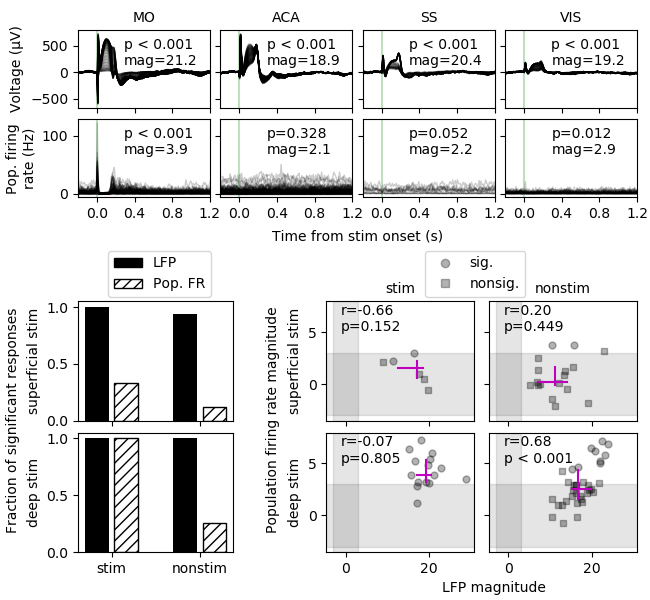

superficial stim: 6/6 stim cortical regions
 LFP: median=17.05, [12.65, 18.55]
 POP spiking: median=1.58, [0.62, 2.19]
superficial stim: 16/17 nonstim cortical regions
 LFP: median=11.24, [7.21, 14.07]
 POP spiking: median=0.20, [-0.13, 1.66]
deep stim: 15/15 stim cortical regions
 LFP: median=19.41, [17.06, 20.56]
 POP spiking: median=3.87, [3.24, 5.33]
deep stim: 35/35 nonstim cortical regions
 LFP: median=16.82, [15.36, 19.87]
 POP spiking: median=2.54, [1.56, 4.37]


In [146]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
comp = {'excited': 'firebrick', 'inhibited': 'mediumblue'}
plot_win = [-0.2, 1.2]
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

## Plot params ##
tracetext = (0.35, 0.9)
#####

fig = plt.figure(figsize=(6.5, 6))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.12, right=0.98, top=0.95, bottom=0.08, height_ratios=[2,3], hspace=0.5)
tracegs = gs[0].subgridspec(ncols=1, nrows=2, hspace=0.15)
LFPgs = tracegs[0].subgridspec(ncols=len(plot_regs), nrows=1, wspace=0.08)
POPgs = tracegs[1].subgridspec(ncols=len(plot_regs), nrows=1, wspace=0.08)
metricgs = gs[1].subgridspec(ncols=2, nrows=1, wspace=0.4, width_ratios=[1,2])
FRgs = metricgs[0].subgridspec(ncols=1, nrows=2, hspace=0.1, wspace=0.1)
FRaxs = [fig.add_subplot(ss) for ss in FRgs]
AUCgs = metricgs[1].subgridspec(ncols=2, nrows=2, hspace=0.1, wspace=0.1)

LFPaxs = []
POPaxs = []
for ii, regi in enumerate(plot_regs):
    if ii == 0:
        LFPaxs.append(fig.add_subplot(LFPgs[ii]))
        POPaxs.append(fig.add_subplot(POPgs[ii]))
    else:
        LFPaxs.append(fig.add_subplot(LFPgs[ii], sharex=LFPaxs[0], sharey=LFPaxs[0]))
        plt.setp(LFPaxs[ii].get_yticklabels(), visible=False)
        POPaxs.append(fig.add_subplot(POPgs[ii], sharex=POPaxs[0], sharey=POPaxs[0]))
        plt.setp(POPaxs[ii].get_yticklabels(), visible=False)
    LFPtime = example_traces['LFP'][plot_stim][plot_state][regi][0]
    LFPtraces = example_traces['LFP'][plot_stim][plot_state][regi][1]
    LFPaxs[ii].axvline(0, color='g', alpha=0.25)
    LFPaxs[ii].plot(LFPtime, LFPtraces, color='k', linewidth=1, alpha=0.2)
    LFPaxs[ii].set_title(regi)
    LFPaxs[ii].set_xlim(plot_win)
    LFPaxs[ii].set_xticks(np.arange(0, plot_win[1]+0.1, 0.4))
    LFPaxs[ii].set_xticklabels([])
    LFPpval = example_df['LFP_p'][example_df['region'] == regi].values[0]
    LFPmag = example_df['LFPmag'][example_df['region'] == regi].values[0]
    if LFPpval < 0.001:
        LFPaxs[ii].annotate('p < 0.001\nmag={:.1f}'.format(LFPmag),
            xy=tracetext, xycoords='axes fraction', ha='left', va='top')
    else:
        LFPaxs[ii].annotate('p={:.3f}\nmag={:.1f}'.format(LFPpval, LFPmag),
            xy=tracetext, xycoords='axes fraction', ha='left', va='top')
    
    POPtime = example_traces['POPFR'][plot_stim][plot_state][regi][0]
    POPtraces = example_traces['POPFR'][plot_stim][plot_state][regi][1]
    POPaxs[ii].axvline(0, color='g', alpha=0.25)
    POPaxs[ii].plot(POPtime, POPtraces, color='k', linewidth=1, alpha=0.2)
    POPaxs[ii].set_xlim(plot_win)
    POPaxs[ii].set_xticks(np.arange(0, plot_win[1]+0.1, 0.4))
    POPpval = example_df['POPFR_p'][example_df['region'] == regi].values[0]
    POPmag = example_df['POPFRmag'][example_df['region'] == regi].values[0]
    if POPpval < 0.001:
        POPaxs[ii].annotate('p < 0.001\nmag={:.1f}'.format(POPmag),
            xy=tracetext, xycoords='axes fraction', ha='left', va='top')
    else:
        POPaxs[ii].annotate('p={:.3f}\nmag={:.1f}'.format(POPpval, POPmag),
            xy=tracetext, xycoords='axes fraction', ha='left', va='top')

LFPaxs[0].set_ylabel('Voltage (\u03bcV)')
POPaxs[0].set_ylabel('Pop. firing\nrate (Hz)')
fig.text(0.55, 0.6, 'Time from stim onset (s)', ha='center')

AUCaxs = []
for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        if (rowi == 0) & (coli == 0):
            AUCax = fig.add_subplot(AUCgs[rowi, coli])
            AUCaxs.append(AUCax)
        else:
            AUCax = fig.add_subplot(AUCgs[rowi, coli], sharex=AUCaxs[0], sharey=AUCaxs[0])
            AUCaxs.append(AUCax)
        
        AUCax.axvspan(-3, 3, color='k', alpha=0.1)
        AUCax.axhspan(-3, 3, color='k', alpha=0.1)
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
        print('{} stim: {:d}/{:d} {} cortical regions'.format(
            depthi, np.sum(dfa['LFP_p'].values < sigalpha), len(dfa), stimlabel))
        sigmask = (dfa['LFP_p'].values < sigalpha) * (dfa['POPFR_p'].values < sigalpha)
        AUCax.scatter(dfa['LFPmag'].values[sigmask], dfa['POPFRmag'].values[sigmask], c='k', marker='o', s=25, alpha=0.3)
        AUCax.scatter(dfa['LFPmag'].values[~sigmask], dfa['POPFRmag'].values[~sigmask], c='k', marker='s', s=25, alpha=0.3)
        ## Add median and quartile error bars ##
        AUCax.plot(np.repeat(np.median(dfa['LFPmag'].values), 2), np.percentile(dfa['POPFRmag'].values, [25, 75]), color='m')
        AUCax.plot(np.percentile(dfa['LFPmag'].values, [25, 75]), np.repeat(np.median(dfa['POPFRmag'].values), 2), color='m')
        print(' LFP: median={:.2f}, [{:.2f}, {:.2f}]'.format(
            np.median(dfa['LFPmag'].values), np.percentile(dfa['LFPmag'].values,25), np.percentile(dfa['LFPmag'].values,75)))
        print(' POP spiking: median={:.2f}, [{:.2f}, {:.2f}]'.format(np.median(dfa['POPFRmag'].values),
            np.percentile(dfa['POPFRmag'].values,25), np.percentile(dfa['POPFRmag'].values,75)))
        ## Linear regression ##
        res = stats.linregress(dfa['LFPmag'].values, dfa['POPFRmag'].values)
        if res.pvalue < 0.001:
            AUCax.annotate(
                'r={:.2f}\np < 0.001'.format(res.rvalue), xy=(0.1, 0.85), xycoords='axes fraction', ha='left', va='center'
            )
        else:
            AUCax.annotate(
                'r={:.2f}\np={:.3f}'.format(res.rvalue, res.pvalue), xy=(0.1, 0.85), xycoords='axes fraction',
                ha='left', va='center'
            )
        if rowi == 0:
            AUCax.set_title(stimlabel)
            plt.setp(AUCax.get_xticklabels(), visible=False)
        if coli == 0:
            AUCax.set_ylabel('{} stim'.format(depthi))
            FRaxs[rowi].set_ylabel('{} stim'.format(depthi))
        else:
            plt.setp(AUCax.get_yticklabels(), visible=False)
        
        fractLFP = np.sum(dfa['LFP_p'].values < sigalpha) / len(dfa)
        fractPOP = np.sum(dfa['POPFR_p'].values < sigalpha) / len(dfa)
        
        FRaxs[rowi].bar(locs1[coli, 0], fractLFP, color='k')
        FRaxs[rowi].bar(locs1[coli, 1], fractPOP, color='w', edgecolor='k', hatch='///')
        FRaxs[rowi].set_xticks(np.mean(locs1[:, :-1], axis=1))
plt.setp(FRaxs[0].get_xticklabels(), visible=False)
FRaxs[1].set_xticklabels(ctx_stim.keys())

## Add legends ##
barleg = [
    Patch(facecolor='k', edgecolor='k', label='LFP'),
    Patch(facecolor='w', edgecolor='k', hatch='///', label='Pop. FR'),
]
FRaxs[0].legend(handles=barleg, bbox_to_anchor=(0.15, 0.98))
AUCleg = [
    Line2D([0], [0], linestyle='none', c='k', marker='o', alpha=0.3, label='sig.'),
    Line2D([0], [0], linestyle='none', c='k', marker='s', alpha=0.3, label='nonsig.')
]
AUCaxs[0].legend(handles=AUCleg, bbox_to_anchor=(0.62, 0.98))                

## Axes labels ##
fig.text(0.41, 0.3, 'Population firing rate magnitude', va='center', rotation='vertical')
fig.text(0.68, 0.02, 'LFP magnitude', va='center')
fig.text(0.01, 0.3, 'Fraction of significant responses', va='center', rotation='vertical')


## Save ##
figname = 'Fig3_v6_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

#### Plot the LFP-units comparison only

<IPython.core.display.Javascript object>


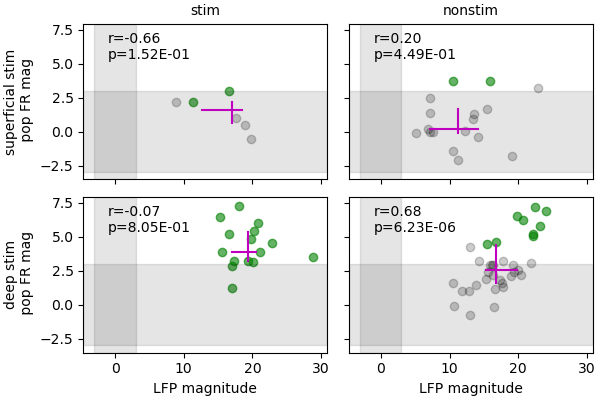

In [50]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

fig, axs = plt.subplots(
    nrows=len(compare), ncols=len(ctx_stim), figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
#         axs[rowi, coli].axvline(1, color='k', linewidth=1, linestyle='dashed', alpha=0.5)
#         axs[rowi, coli].axhline(1, color='k', linewidth=1, linestyle='dashed', alpha=0.5)
        axs[rowi, coli].axvspan(-3, 3, color='k', alpha=0.1)
        axs[rowi, coli].axhspan(-3, 3, color='k', alpha=0.1)
        
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
#         axs[rowi, coli].scatter(
#             dfa['LFPmag'].values, dfa['POPFRmag'].values, c='b', marker='o', alpha=0.4
#         )
        sigmask = (dfa['LFP_p'].values < sigalpha) * (dfa['POPFR_p'].values < sigalpha)
        axs[rowi, coli].scatter(
            dfa['LFPmag'].values[sigmask], dfa['POPFRmag'].values[sigmask], c='g', marker='o', alpha=0.6
        )
        axs[rowi, coli].scatter(
            dfa['LFPmag'].values[~sigmask], dfa['POPFRmag'].values[~sigmask], c='k', marker='o', alpha=0.2
        )
        
        ## Add median and quartile error bars ##
        axs[rowi, coli].plot(
            np.repeat(np.median(dfa['LFPmag'].values), 2), np.percentile(dfa['POPFRmag'].values, [25, 75]), color='m'
        )
        axs[rowi, coli].plot(
            np.percentile(dfa['LFPmag'].values, [25, 75]), np.repeat(np.median(dfa['POPFRmag'].values), 2), color='m'
        )
        
        
        ## Linear regression ##
        res = stats.linregress(dfa['LFPmag'].values, dfa['POPFRmag'].values)
        axs[rowi, coli].annotate(
            'r={:.2f}\np={:.3f}'.format(res.rvalue, res.pvalue), xy=(0.1, 0.85), xycoords='axes fraction',
            ha='left', va='center'
        )
#         if res.pvalue < sigalpha:
#             axs[rowi, coli]
        

        if rowi == 1:
            axs[rowi, coli].set_xlabel('LFP magnitude')
        else:
            axs[rowi, coli].set_title(stimlabel)
        
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\n pop FR mag'.format(depthi))

<IPython.core.display.Javascript object>


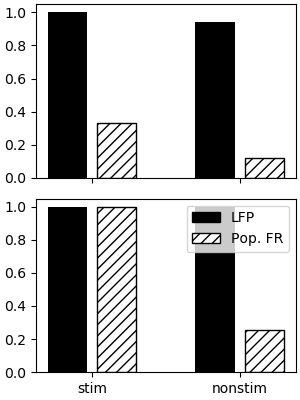

In [99]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

fig, axs = plt.subplots(
    nrows=len(compare), ncols=1, figsize=(3, 4), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
        
        fractLFP = np.sum(dfa['LFP_p'].values < sigalpha) / len(dfa)
        fractPOP = np.sum(dfa['POPFR_p'].values < sigalpha) / len(dfa)
        
        axs[rowi].bar(locs1[coli, 0], fractLFP, color='k')
        axs[rowi].bar(locs1[coli, 1], fractPOP, color='w', edgecolor='k', hatch='///')
#         axs[rowi].set_ylabel('Fraction of significant responses')
        
axs[1].set_xticks(np.mean(locs1[:, :-1], axis=1))
axs[1].set_xticklabels(ctx_stim.keys())

## Make a legend ##
barleg = [
    Patch(facecolor='k', edgecolor='k', label='LFP'),
    Patch(facecolor='w', edgecolor='k', hatch='///', label='Pop. FR'),
]
axs[1].legend(handles=barleg)

## Make figure 4 (was part of fig 3)

<IPython.core.display.Javascript object>


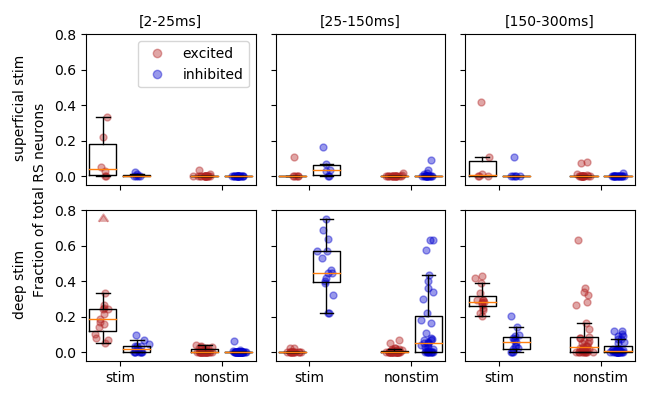

In [164]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
comp = {'excited': 'firebrick', 'inhibited': 'mediumblue'}
plot_win = [-0.2, 1.2]
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()

fig, axs = plt.subplots(2, len(response_window), figsize=(6.5, 4), sharex=True, sharey=True)
fig.set_tight_layout({'rect': [0.06, 0, 1, 1]})#, 'pad': 1.0, 'w_pad': 0.5})

for rowi, depthi in enumerate(compare):
    for ii, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        for coli, windi in enumerate(response_window.keys()):
            dfb = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ]
            for kk, (resp_type, rcolor) in enumerate(comp.items()):
                unit_fraction = dfb[resp_type].values
                xs = np.random.normal(locs1[ii,kk], 0.1, len(unit_fraction))
                axs[rowi, coli].boxplot(unit_fraction, positions=[locs1[ii,kk]], widths=[0.8], showfliers=False)
                axs[rowi, coli].scatter(xs, unit_fraction, c=rcolor, marker='o', s=25, alpha=0.4)
            if (ii == 0) and (rowi == 0):
                axs[rowi, coli].set_title('[{:d}-{:d}ms]'.format(
                    int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))

axs[rowi, coli].set_ylim([-0.05, 0.8])
axs[rowi, coli].set_xticks(np.mean(locs1[:,:-1], axis=1))
axs[rowi, coli].set_xticklabels(ctx_stim.keys())

fig.text(0.05, 0.5, 'Fraction of total RS neurons', va='center', rotation='vertical')
fig.text(0.02, 0.73, 'superficial stim', va='center', rotation='vertical')
fig.text(0.02, 0.29, 'deep stim', va='center', rotation='vertical')

# Plot cut-off data point in fraction ##
axs[1,0].scatter(0, 0.78, c='firebrick', marker=6, s=50, alpha=0.4)

## Add legends ##
FRhandles = []
for resp_type, rcolor in comp.items():
    FRhandles.append(Line2D([],[], color=rcolor, linestyle='none', marker='o', markersize=6, alpha=0.4, label=resp_type))
axs[0,0].legend(handles=FRhandles)

## Save ##
figname = 'Fig3-4_v6_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

In [174]:
for depthi in ['superficial', 'deep']:
    print('{}'.format(depthi))
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
            (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0])
        ]
        numsubs = len(np.unique(stimdf['subjects'].values))
        numunits = np.sum(stimdf['num_units'].values)
        print('  {}: {:d} mice, n = {:d} units'.format(stimlabel, numsubs, numunits))
#         print(np.unique(stimdf['subjects'].values))

superficial
  stim: 6 mice, n = 870 units
  nonstim: 7 mice, n = 4110 units
deep
  stim: 15 mice, n = 2442 units
  nonstim: 15 mice, n = 8313 units


In [184]:
for windi in response_window.keys():
    print(windi)
    for depthi in ['superficial', 'deep']:
        print('{}'.format(depthi))
        for stimlabel, stiminfo in ctx_stim.items():
            stimdf = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ]
            print(' {}'.format(stimlabel))
            for modi in ['excited', 'inhibited', 'significant']:
                print('  {}: median={:.2f} [{:.2f}-{:.2f}]'.format(
                    modi, np.median(stimdf[modi].values), np.percentile(stimdf[modi].values, 25),
                    np.percentile(stimdf[modi].values, 75)
                ))
        print('')
    print('')

early
superficial
 stim
  excited: median=0.04 [0.01-0.18]
  inhibited: median=0.00 [0.00-0.01]
  significant: median=0.05 [0.03-0.18]
 nonstim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.00 [0.00-0.00]

deep
 stim
  excited: median=0.19 [0.12-0.25]
  inhibited: median=0.02 [0.00-0.04]
  significant: median=0.21 [0.17-0.27]
 nonstim
  excited: median=0.00 [0.00-0.02]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.00 [0.00-0.02]


mid
superficial
 stim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.03 [0.01-0.06]
  significant: median=0.05 [0.03-0.10]
 nonstim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.00 [0.00-0.00]
  significant: median=0.00 [0.00-0.01]

deep
 stim
  excited: median=0.00 [0.00-0.00]
  inhibited: median=0.45 [0.40-0.57]
  significant: median=0.45 [0.40-0.57]
 nonstim
  excited: median=0.00 [0.00-0.01]
  inhibited: median=0.06 [0.00-0.20]
  significant: median=0.07 [0.02-0.21]


la

In [188]:
for windi in response_window.keys():
    print(windi)
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
            (all_subs_sig_df['stim_cortex'] == stiminfo[0]) & (all_subs_sig_df['window'] == windi)
        ]
        print(' {}'.format(stimlabel))
        for modi in ['excited', 'inhibited', 'significant']:
            print('  {}: median={:.3f} [{:.3f}-{:.3f}]'.format(
                modi, np.median(stimdf[modi].values), np.percentile(stimdf[modi].values, 25),
                np.percentile(stimdf[modi].values, 75)
            ))
    print('')

early
 stim
  excited: median=0.198 [0.069-0.245]
  inhibited: median=0.019 [0.000-0.034]
  significant: median=0.218 [0.103-0.265]
 nonstim
  excited: median=0.006 [0.000-0.006]
  inhibited: median=0.002 [0.000-0.000]
  significant: median=0.008 [0.000-0.011]

mid
 stim
  excited: median=0.008 [0.000-0.000]
  inhibited: median=0.352 [0.167-0.531]
  significant: median=0.360 [0.167-0.556]
 nonstim
  excited: median=0.006 [0.000-0.005]
  inhibited: median=0.099 [0.000-0.084]
  significant: median=0.105 [0.000-0.096]

late
 stim
  excited: median=0.239 [0.204-0.298]
  inhibited: median=0.050 [0.000-0.083]
  significant: median=0.290 [0.222-0.393]
 nonstim
  excited: median=0.065 [0.000-0.067]
  inhibited: median=0.018 [0.000-0.017]
  significant: median=0.084 [0.000-0.085]



In [192]:
for windi in response_window.keys():
    print(windi)
    for depthi in ['superficial', 'deep']:
        print('{}'.format(depthi))
        for stimlabel, stiminfo in ctx_stim.items():
            stimdf = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ]
            print(' {}'.format(stimlabel))
            for modi in ['excited', 'inhibited', 'significant']:
                print('  {}: mean={:.3f} [min {:.3f}, max {:.3f}]'.format(
                    modi, np.mean(stimdf[modi].values), np.min(stimdf[modi].values), np.max(stimdf[modi].values)
                ))
        print('')
    print('')

early
superficial
 stim
  excited: mean=0.106 [min 0.000, max 0.333]
  inhibited: mean=0.006 [min 0.000, max 0.025]
  significant: mean=0.113 [min 0.000, max 0.333]
 nonstim
  excited: mean=0.003 [min 0.000, max 0.037]
  inhibited: mean=0.000 [min 0.000, max 0.000]
  significant: mean=0.003 [min 0.000, max 0.037]

deep
 stim
  excited: mean=0.235 [min 0.056, max 1.000]
  inhibited: mean=0.025 [min 0.000, max 0.096]
  significant: mean=0.260 [min 0.056, max 1.000]
 nonstim
  excited: mean=0.008 [min 0.000, max 0.040]
  inhibited: mean=0.003 [min 0.000, max 0.067]
  significant: mean=0.011 [min 0.000, max 0.067]


mid
superficial
 stim
  excited: mean=0.019 [min 0.000, max 0.111]
  inhibited: mean=0.051 [min 0.000, max 0.167]
  significant: mean=0.070 [min 0.000, max 0.167]
 nonstim
  excited: mean=0.001 [min 0.000, max 0.017]
  inhibited: mean=0.009 [min 0.000, max 0.091]
  significant: mean=0.010 [min 0.000, max 0.091]

deep
 stim
  excited: mean=0.003 [min 0.000, max 0.025]
  inhibite

In [189]:
for windi in response_window.keys():
    print(windi)
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
            (all_subs_sig_df['stim_cortex'] == stiminfo[0]) & (all_subs_sig_df['window'] == windi)
        ]
        print(' {}'.format(stimlabel))
        for modi in ['excited', 'inhibited', 'significant']:
            print('  {}: mean={:.3f} [min {:.3f}, max {:.3f}]'.format(
                modi, np.mean(stimdf[modi].values), np.min(stimdf[modi].values), np.max(stimdf[modi].values)
            ))
    print('')

early
 stim
  excited: mean=0.198 [min 0.000, max 1.000]
  inhibited: mean=0.019 [min 0.000, max 0.096]
  significant: mean=0.218 [min 0.000, max 1.000]
 nonstim
  excited: mean=0.006 [min 0.000, max 0.040]
  inhibited: mean=0.002 [min 0.000, max 0.067]
  significant: mean=0.008 [min 0.000, max 0.067]

mid
 stim
  excited: mean=0.008 [min 0.000, max 0.111]
  inhibited: mean=0.352 [min 0.000, max 0.750]
  significant: mean=0.360 [min 0.000, max 0.750]
 nonstim
  excited: mean=0.006 [min 0.000, max 0.071]
  inhibited: mean=0.099 [min 0.000, max 0.636]
  significant: mean=0.105 [min 0.000, max 0.636]

late
 stim
  excited: mean=0.239 [min 0.000, max 0.429]
  inhibited: mean=0.050 [min 0.000, max 0.207]
  significant: mean=0.290 [min 0.000, max 0.500]
 nonstim
  excited: mean=0.065 [min 0.000, max 0.636]
  inhibited: mean=0.018 [min 0.000, max 0.122]
  significant: mean=0.084 [min 0.000, max 0.636]



In [190]:
for windi in response_window.keys():
    print(windi)
    for stimlabel, stiminfo in ctx_stim.items():
        stimdf = all_subs_sig_df[
            (all_subs_sig_df['state'] == plot_state) & (all_subs_sig_df['stim_level'] == plot_stim) &
            (all_subs_sig_df['stim_cortex'] == stiminfo[0]) & (all_subs_sig_df['window'] == windi)
        ]
        print(' {}'.format(stimlabel))
        for modi in ['excited', 'inhibited', 'significant']:
            print('  {}: {:d} subs above zero'.format(modi, np.sum(stimdf[modi].values > 0)))
    print('')

early
 stim
  excited: 19 subs above zero
  inhibited: 10 subs above zero
  significant: 20 subs above zero
 nonstim
  excited: 14 subs above zero
  inhibited: 4 subs above zero
  significant: 16 subs above zero

mid
 stim
  excited: 3 subs above zero
  inhibited: 19 subs above zero
  significant: 20 subs above zero
 nonstim
  excited: 14 subs above zero
  inhibited: 30 subs above zero
  significant: 34 subs above zero

late
 stim
  excited: 18 subs above zero
  inhibited: 13 subs above zero
  significant: 18 subs above zero
 nonstim
  excited: 29 subs above zero
  inhibited: 19 subs above zero
  significant: 32 subs above zero



In [197]:
for windi in response_window.keys():
    print(windi)
    for depthi in ['superficial', 'deep']:
        print('{}'.format(depthi))
        for stimlabel, stiminfo in ctx_stim.items():
            stimdf = all_subs_sig_df[
                (all_subs_sig_df['stim_depth'] == depthi) & (all_subs_sig_df['state'] == plot_state) &
                (all_subs_sig_df['stim_level'] == plot_stim) & (all_subs_sig_df['stim_cortex'] == stiminfo[0]) &
                (all_subs_sig_df['window'] == windi)
            ]
            collapse_regions = stimdf.groupby('subjects').max()
            print(' {}'.format(stimlabel))
            for modi in ['excited', 'inhibited', 'significant']:
                print('  {}: {:d}/{:d} subs above zero'.format(
                    modi, np.sum(collapse_regions[modi].values > 0), len(collapse_regions)))
        print('')
    print('')

early
superficial
 stim
  excited: 4/6 subs above zero
  inhibited: 2/6 subs above zero
  significant: 5/6 subs above zero
 nonstim
  excited: 2/7 subs above zero
  inhibited: 0/7 subs above zero
  significant: 2/7 subs above zero

deep
 stim
  excited: 15/15 subs above zero
  inhibited: 8/15 subs above zero
  significant: 15/15 subs above zero
 nonstim
  excited: 7/15 subs above zero
  inhibited: 3/15 subs above zero
  significant: 8/15 subs above zero


mid
superficial
 stim
  excited: 1/6 subs above zero
  inhibited: 4/6 subs above zero
  significant: 5/6 subs above zero
 nonstim
  excited: 2/7 subs above zero
  inhibited: 3/7 subs above zero
  significant: 4/7 subs above zero

deep
 stim
  excited: 2/15 subs above zero
  inhibited: 15/15 subs above zero
  significant: 15/15 subs above zero
 nonstim
  excited: 10/15 subs above zero
  inhibited: 14/15 subs above zero
  significant: 15/15 subs above zero


late
superficial
 stim
  excited: 3/6 subs above zero
  inhibited: 1/6 subs abo

In [196]:
stimdf.groupby('subjects').max()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_units,stim_level,state,window,excited,inhibited,significant
subjects,,,,,,,,,,,,,
551397_MOs_deep,MOs_deep,551397,MO,deep,SS,False,113,medium,resting,late,0.017699,0.118644,0.135593
551399_MOs_deep,MOs_deep,551399,MO,deep,SS,False,95,medium,resting,late,0.133333,0.073684,0.133333
569062_MOs_deep,MOs_deep,569062,MO,deep,SS,False,174,medium,resting,late,0.017241,0.017241,0.034483
569064_MOs_deep,MOs_deep,569064,MO,deep,VIS,False,50,medium,resting,late,0.020000,0.020000,0.040000
569068_MOs_deep,MOs_deep,569068,MO,deep,SS,False,66,medium,resting,late,0.000000,0.060606,0.060606
569069_MOs_deep,MOs_deep,569069,MO,deep,VIS,False,59,medium,resting,late,0.341463,0.121951,0.463415
569072_SSp_deep,SSp_deep,569072,SS,deep,VIS,False,206,medium,resting,late,0.083333,0.052632,0.105263
569073_MOs_deep,MOs_deep,569073,MO,deep,VIS,False,63,medium,resting,late,0.000000,0.015873,0.015873
569073_SSp_deep,SSp_deep,569073,SS,deep,VIS,False,100,medium,resting,late,0.088889,0.000000,0.088889


## Original analyses and plots

Old version, plots inset with magnitude calculation.

## GRC poster analyses and plots

#### Make example plot and LFP/MUA mag plot for GRC poster

### Make fraction of excited/inhibited cells: stim/nonstim/thal